In [1]:
pip install gpflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%config Completer.use_jedi = False

In [3]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython
import numpy as np
import time
import os
plt.style.use('ggplot')
import pandas as pd
%matplotlib inline
from data_wrangler import batcher
import warnings
warnings.filterwarnings("ignore")
import tensorflow_probability as tfp
from gpflow.kernels import Kernel
import gpflow
from gpflow.utilities import print_summary, set_trainable, to_default_float

In [790]:
gcm_nigeria = pd.read_csv("/Users/omernivron/Downloads/hw2/ipsl.csv").iloc[:, 3:]
era_nigeria = pd.read_csv("/Users/omernivron/Downloads/hw2/era.csv").iloc[:, 4:]

In [791]:
era_nigeria = era_nigeria[(era_nigeria.year >= 1948) & (era_nigeria.year < 2015)]
gcm_nigeria = gcm_nigeria[(gcm_nigeria.year >= 1948) & (gcm_nigeria.year < 2015) & (gcm_nigeria.axis_nbounds == 0)]

In [792]:
df = gcm_nigeria.groupby(['lat', 'lon']).mean().reset_index()
df['loc_key'] = np.arange(df.shape[0])
df = df[['lat', 'lon', 'loc_key']]
gcm_nigeria = pd.merge(gcm_nigeria, df, how='left', on=['lat', 'lon'])

In [793]:
df_e = era_nigeria.groupby(['lat', 'lon']).mean().reset_index()
df_e['loc_key'] = np.arange(df_e.shape[0])
df_e = df_e[['lat', 'lon', 'loc_key']]
era_nigeria = pd.merge(era_nigeria, df_e, how='left', on=['lat', 'lon'])

In [1028]:
era_nigeria['day'] 

0          1
1          2
2          3
3          4
4          5
          ..
464963    27
464964    28
464965    29
464966    30
464967    31
Name: day, Length: 464968, dtype: int64

In [868]:
era_nigeria['t'] = era_nigeria['year'] + ((era_nigeria['month'] - 1)/ 12) + ((era_nigeria['day'] - 1)/ (12 *31))
gcm_nigeria['t'] = gcm_nigeria['year'] + ((gcm_nigeria['month'] - 1)/ 12)+ ((gcm_nigeria['day'] - 1)/ (12 *31))

In [869]:
era_mon_nigeria = era_nigeria.groupby(['grid_val','loc_key','t']).mean().reset_index()
gcm_mon_nigeria = gcm_nigeria.groupby(['grid_val','loc_key', 't']).mean().reset_index()

In [870]:
era_mon_nigeria['tmax'] = era_mon_nigeria['tmax'] - 273.15 
gcm_mon_nigeria['tasmax'] = gcm_mon_nigeria['tasmax'] - 273.15 

In [871]:
μ_era_past = era_mon_nigeria[(era_mon_nigeria.t > 1948) & (era_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).mean()['tmax'].reset_index()
μ_gcm_past = gcm_mon_nigeria[(gcm_mon_nigeria.t > 1948) & (gcm_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).mean()['tasmax'].reset_index()

σ_era_past = era_mon_nigeria[(era_mon_nigeria.t > 1948) & (era_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).std()['tmax'].reset_index()
σ_gcm_past = gcm_mon_nigeria[(gcm_mon_nigeria.t > 1948) & (gcm_mon_nigeria.t  < 1989)].groupby(['grid_val', 'loc_key']).std()['tasmax'].reset_index()

In [872]:
era_mon_nigeria = pd.merge(era_mon_nigeria, μ_era_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_mu'))
era_mon_nigeria = pd.merge(era_mon_nigeria, σ_era_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_sigma'))


In [873]:
gcm_mon_nigeria = pd.merge(gcm_mon_nigeria, μ_gcm_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_mu'))
gcm_mon_nigeria = pd.merge(gcm_mon_nigeria, σ_gcm_past, on=['grid_val', 'loc_key'], how='left', suffixes=('', '_sigma'))

In [874]:
era_mon_nigeria = era_mon_nigeria[era_mon_nigeria.grid_val!=25]
era_mon_nigeria = era_mon_nigeria[era_mon_nigeria.grid_val!=8]
gcm_mon_nigeria = gcm_mon_nigeria[gcm_mon_nigeria.grid_val!=25]

In [875]:
era_mon_nigeria['era_adj_tmax'] = (era_mon_nigeria.tmax - era_mon_nigeria.tmax_mu) / era_mon_nigeria.tmax_sigma 
gcm_mon_nigeria['gcm_adj_tasmax'] = (gcm_mon_nigeria.tasmax - gcm_mon_nigeria.tasmax_mu) / gcm_mon_nigeria.tasmax_sigma

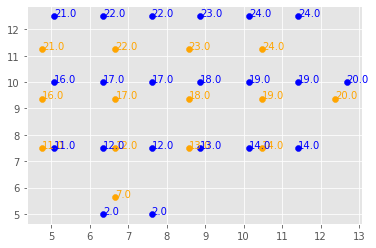

In [876]:

a = era_mon_nigeria.groupby(['lat', 'lon']).mean().reset_index()
b = gcm_mon_nigeria.groupby(['lat', 'lon']).mean().reset_index()
plt.scatter(a['lat'], a['lon'], c='orange')
plt.scatter(b['lat'], b['lon'], c='b') 
for i in range(a.shape[0]):
    plt.text(a['lat'][i], a['lon'][i], str(a['grid_val'][i]), c='orange')
for i in range(b.shape[0]):
    plt.text(b['lat'][i], b['lon'][i], str(b['grid_val'][i]), c='b')

In [877]:
# prepare data for batcher_bc
array = pd.merge(era_mon_nigeria, gcm_mon_nigeria, on=['grid_val', 't'], how='inner', suffixes=('', '_gcm'))
### check if merge is correct
# array.loc[array.grid_val==r_grid_val, ['loc_key', 'loc_key_gcm', 't', 'adj_tmax', 'adj_tasmax']]
####

In [878]:
array.shape

(464968, 25)

### GP

In [929]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t < 1989) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
x_tr, y_tr = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180, batch_size=5000, abs_t = True)

In [930]:
x2 = np.concatenate([np.zeros((180, 1)), np.ones((180, 1))], axis=0)[np.newaxis, :, :]
x2 = np.repeat(x2, 5000, axis=0)
x_tr = np.concatenate([x_tr, x2], axis=-1)

In [931]:
k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) + gpflow.kernels.White(0.0005)


In [932]:
gp_model = gpflow.models.GPR((x_tr[0, :, :], y_tr[0, :].reshape(-1, 1)),  kernel=k1)


In [933]:
k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) + gpflow.kernels.White(0.0005)
print_summary(k1)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance                │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  1      │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  1      │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  1      │
├───────────────

In [1007]:
# Train the model for 5000 sequences (each of length 360)
opt_per_param = 8
idxs = np.random.choice(np.arange(5000), size=200).astype(int)
sum_like = []
var = np.random.uniform(0.01, 1, opt_per_param)
length = np.random.uniform(0.01, 1, opt_per_param)
var_len = np.concatenate([np.repeat(var, opt_per_param).reshape(-1, 1), np.tile(length, opt_per_param).reshape(-1, 1)], axis=1)
for ix, vals in enumerate(var_len):
    print(ix, vals)
    like = []
    for i in idxs:
        opt = gpflow.optimizers.Scipy()
        k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) 
        ###########################################################################
        # Parameter bounds (otherwise the optimization might go crazy)

        k1.kernels[0].variance  = gpflow.Parameter(
            0.5,
            transform=tfp.bijectors.SoftClip(
                gpflow.utilities.to_default_float(0.001),
                gpflow.utilities.to_default_float(100),
            ),)
        k1.kernels[0].lengthscales  = gpflow.Parameter(
            0.5,
            transform=tfp.bijectors.SoftClip(
                gpflow.utilities.to_default_float(0.001),
                gpflow.utilities.to_default_float(20),
            ),)
        k1.kernels[2].variance  = gpflow.Parameter(
        0.5,
        transform=tfp.bijectors.SoftClip(
            gpflow.utilities.to_default_float(0.01),
            gpflow.utilities.to_default_float(1),
        ),)
        ###########################################################################

        gp_model = gpflow.models.GPR((x_tr[i, :, :], y_tr[i, :].reshape(-1, 1)),  kernel=k1)
        gp_model.kernel.kernels[1].kernels[0].variance.assign(1)
        gp_model.kernel.kernels[1].kernels[1].lengthscales.assign(vals[1])
        gp_model.kernel.kernels[1].kernels[1].variance.assign(vals[0])
        set_trainable(gp_model.kernel.kernels[1].kernels[0].variance  , False)    
        set_trainable(gp_model.kernel.kernels[1].kernels[1].lengthscales  , False)
        set_trainable(gp_model.kernel.kernels[1].kernels[1].variance  , False)

        if ((i-1) % 50 == 0) & (i > 1):
            print(i)
            print_summary(gp_model)
        gp_model = gpflow.models.GPR((x_tr[i, :, :], y_tr[i, :].reshape(-1, 1)),  kernel=k1)
        opt.minimize(gp_model.training_loss, gp_model.trainable_variables)
        # print(i)
        # print_summary(gp_model)
        like.append(gp_model.training_loss().numpy())
        if (i % 50 == 0) & (i > 0):
            IPython.display.clear_output(wait=True)
            print(i)
            print_summary(gp_model)
    
    sum_like.append(np.sum(like))
    print(ix, np.sum(like))

3900
╒═══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                          │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞═══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance                │ Parameter │ SoftClip         │         │ True        │ ()      │ float64 │ 0.735917   │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscales            │ Parameter │ SoftClip         │         │ True        │ ()      │ float64 │ 0.125696   │
├───────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].kerne

2023-06-06 00:45:58.620204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:45:59.434765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:46:00.020471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:46:00.742107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:46:01.490653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:46:02.354446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-06 00:46:03.162945: I tensorflow/core/grappler/optimizers/cust

63 28353.987460896693


In [1008]:
max_vals = var_len[np.argmax(sum_like), :]

In [1009]:
print_summary(k1)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ Sum.kernels[0].variance                │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 1.11298  │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 0.157966 │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ False       │ ()      │ float64 │ 1        │
├───────

In [1010]:
max_vals

array([0.03691807, 0.85543542])

#### Test

In [1019]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t >= 1988) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)

In [1020]:
y_te = np.concatenate([np.array(arr_temp.iloc[280:640, 1]), np.array(arr_temp.iloc[280:640, 2])], axis=0)[np.newaxis, :]
x_te = np.concatenate([np.array(arr_temp.iloc[280:640, 0] ), np.array(arr_temp.iloc[280:640, 0] )], axis=0)[np.newaxis, :, np.newaxis]
# uncomment to use relative time and comment out the previous line
# x_te = np.concatenate([np.linspace(1,2,180), np.linspace(1,2,180)], axis=0)[np.newaxis, :, np.newaxis] 
x_te = np.concatenate([x_te, np.concatenate([np.zeros((360, 1)), np.ones((360, 1))], axis=0)[np.newaxis, :, :]], axis=-1)


In [1021]:
opt = gpflow.optimizers.Scipy()

k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) 
###########################################################################
# Parameter bounds (otherwise the optimization might go crazy)

k1.kernels[0].variance  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(100),
    ),)
k1.kernels[0].lengthscales  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(20),
    ),)
k1.kernels[2].variance  = gpflow.Parameter(
0.5,
transform=tfp.bijectors.SoftClip(
    gpflow.utilities.to_default_float(0.0001),
    gpflow.utilities.to_default_float(1),
),)
###########################################################################
gp_model = gpflow.models.GPR((x_te[0, :540, :], y_te[0, :540].reshape(-1, 1)),  kernel=k1)




gp_model.kernel.kernels[1].kernels[0].variance.assign(1)
gp_model.kernel.kernels[1].kernels[1].lengthscales.assign(max_vals[1])
gp_model.kernel.kernels[1].kernels[1].variance.assign(max_vals[0])

set_trainable(gp_model.kernel.kernels[0].variance , False)
set_trainable(gp_model.kernel.kernels[0].lengthscales , False)

In [1022]:
print_summary(k1)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ Sum.kernels[0].variance                │ Parameter │ SoftClip    │         │ False       │ ()      │ float64 │ 0.5       │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ SoftClip    │         │ False       │ ()      │ float64 │ 0.5       │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1         │


In [1023]:
opt.minimize(gp_model.training_loss, gp_model.trainable_variables)

2023-06-06 10:55:20.263942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


      fun: 394.25447211506025
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.13739629e-06, -2.57492717e-04,  2.28251639e-06,  4.61474300e-04,
        4.19666803e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 26
      nit: 17
     njev: 26
   status: 0
  success: True
        x: array([ 1.73459307, -2.87457786, -1.41976086, -0.79639197, -4.25241716])

In [1024]:
mk, vk = gp_model.predict_y(x_te[0, :, :])

In [1027]:
np.argsort(vk[-180:,0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  98,  97,  99,  96, 100,  95,  68, 101,  94,  93,
       102,  92,  91, 103,  90,  69, 104,  89,  88,  70,  87, 105,  71,
        86, 106,  85,  72,  84,  83,  73,  82,  74, 107,  81,  80,  75,
        79,  76,  78,  77, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

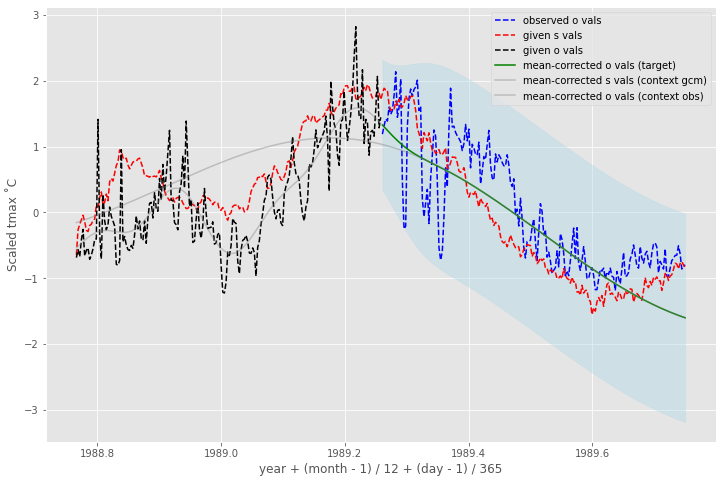

In [1026]:
plt.figure(figsize=(12, 8))
plt.plot(x_te[0, -180:, 0].reshape(-1, 1), y_te[0, -180:].reshape(-1, 1), '--', c='blue', label = 'observed o vals')
plt.plot(x_te[0, :360, 0].reshape(-1, 1), y_te[0, :360].reshape(-1, 1), '--', c='red', label = 'given s vals')
plt.plot(x_te[0, 360:540, 0].reshape(-1, 1), y_te[0, 360:540].reshape(-1, 1), '--', c='black', label = 'given o vals')
plt.plot(x_te[0, -180:, 0], mk[-180:], c='green', label= 'mean-corrected o vals (target)')


plt.plot(x_te[0, :360, 0].reshape(-1, 1), mk[:360, 0], c='gray', label= 'mean-corrected s vals (context gcm)', alpha=0.4)
plt.plot(x_te[0, 360:540, 0].reshape(-1, 1), mk[360:540, 0], c='gray', label= 'mean-corrected o vals (context obs)', alpha=0.4)


plt.fill_between(
    x_te[0, -180:, 0],
    (mk[-180:] - 2 * np.sqrt(vk[-180:]))[:, 0],
    (mk[-180:] + 2 * np.sqrt(vk[-180:]))[:, 0],
    color='lightblue',
    alpha=0.4,
)
# plt.xlabel('(Days since seq. start / 180) + 1')
plt.xlabel('year + (month - 1) / 12 + (d.o.m - 1) / 365')
plt.ylabel('Scaled tmax ˚C')
plt.legend()
plt.show()

In [1083]:
log_dir = "checkpoints_1"
ckpt = tf.train.Checkpoint(model=gp_model)
manager = tf.train.CheckpointManager(ckpt, log_dir, max_to_keep=3)
manager.save()

'checkpoints_1/ckpt-1'

#### Estimating G* 

In [ ]:
# GPflow have an easy access to G* with predict_f, but we could also get using: 
# cov(yt1, yt1) = cov(zt, zt) + var(\epsilon_t)
# cov(yt1, yt2) = cov(zt, zt)
# var(yt1 - yt2) = var(Gt) + 2*var(\epsilon_t)

In [1033]:
num_samples = 10
samples = gp_model.predict_f_samples(x_te[0, :, :], num_samples) 

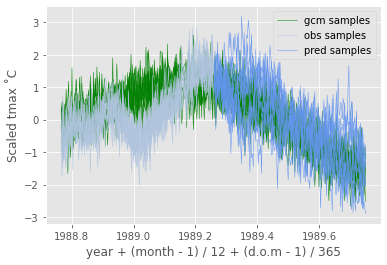

In [1082]:
plt.plot(x_te[0, :360, 0], samples[:, :360, 0].numpy().T, "green", linewidth=0.5)
plt.plot(x_te[0, 360:540, 0], samples[:, 360:540, 0].numpy().T, "lightsteelblue", linewidth=0.5)
plt.plot(x_te[0, 540:720, 0], samples[:, 540:720, 0].numpy().T, "cornflowerblue", linewidth=0.5)
plt.xlabel('year + (month - 1) / 12 + (d.o.m - 1) / 365')
plt.ylabel('Scaled tmax ˚C')
leg = plt.legend( ["gcm samples","obs samples","pred samples"], loc=1)
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('lightsteelblue')
leg.legendHandles[2].set_color('cornflowerblue')
plt.show()


In [1084]:
num_samples = 1000
 # Samples from the GP posterior without noise
samples = gp_model.predict_f_samples(x_te[0, :, :], num_samples) 
# Take the difference between the two samples to get G*
G_star = samples[:, :360, 0].numpy().T - samples[:, 360:720, 0].numpy().T

In [1085]:
G_star.shape

(360, 1000)

In [1144]:
x_te[0, 304, 0]

1989.5994623655913

In [1246]:
print_summary(k1)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ Sum.kernels[0].variance                │ Parameter │ SoftClip    │         │ False       │ ()      │ float64 │ 0.5       │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ SoftClip    │         │ False       │ ()      │ float64 │ 0.5       │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.89711   │


In [1247]:
365 * 0.05

18.25

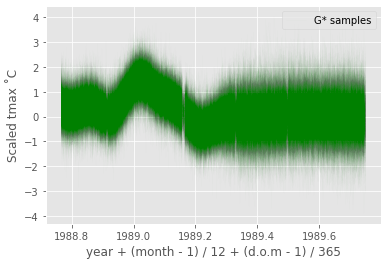

In [1094]:
plt.plot(x_te[0, :360, 0], G_star[:360, :], "green", linewidth=0.5, alpha=0.01)
plt.xlabel('year + (month - 1) / 12 + (d.o.m - 1) / 365')
plt.ylabel('Scaled tmax ˚C')
leg = plt.legend( ["G* samples"], loc=1)
leg.legendHandles[0].set_color('green')

plt.show()

#### Weather vs Climate

In [1096]:
Σ_aa = k1(x_te[0, :, :])[540:, 540:]   
Σ_ab = k1(x_te[0, :, :])[540:, :540]  
Σ_ba = k1(x_te[0, :, :])[:540, 540:]  
Σ_bb = k1(x_te[0, :, :])[:540, :540]   

In [1098]:
μ_a_g_b =  Σ_ab @ np.linalg.inv(Σ_bb) @ ((y_te[0, :540]).reshape(-1, 1) )
Σ_a_g_b = Σ_aa - Σ_ab @ np.linalg.inv(Σ_bb) @ Σ_ba

In [1192]:
num_samples = 10000
Z = np.random.multivariate_normal(μ_a_g_b.numpy().reshape(-1), Σ_a_g_b.numpy(), num_samples)

In [1740]:
plt.style.use('ggplot')

OSError: [Errno 24] Too many open files: '/Users/omernivron/Downloads/figs/fig_0.0.png'

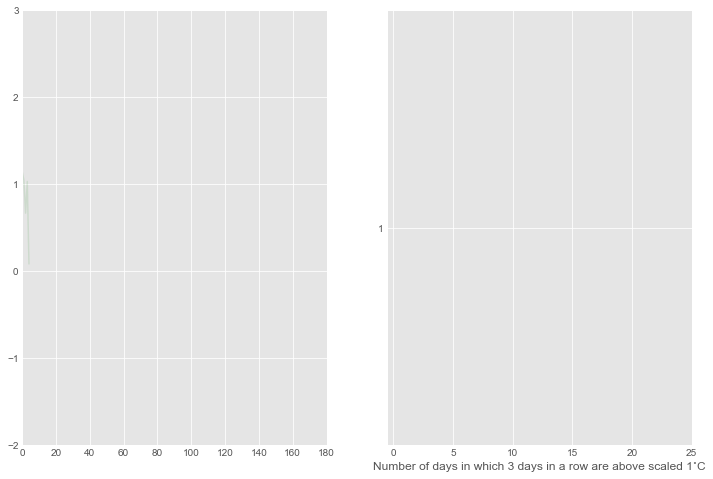

In [1769]:
dict_counts = {}
height = {}
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].set_xlim([0, 180])
ax[0].set_ylim([-2, 3])
ax[1].set_xlim([-.5, 25])
ax[1].set_yticks([0, 1])
ax[1].scatter(0, 1, facecolors='none', edgecolors='none')
ax[1].set_xlabel('Number of days in which 3 days in a row are above scaled 1˚C')

for i in range(10000):
    for j in range(0, 180, 5):
        ax[0].plot(np.arange(j, j+5), Z.T[j:(j+5), i], alpha=0.1, c='green')
        plt.savefig('/Users/omernivron/Downloads/figs/fig_' + str(i + np.round(j/180, 2)) + '.png')
    # calculate # days in which 3 days in a row are above scaled 1˚C
    consec_days = np.concatenate([np.arange(start_ix, start_ix + 178, 1).reshape(-1, 1), np.arange(start_ix+1, start_ix + 179, 1).reshape(-1, 1), np.arange(start_ix+2, start_ix + 180, 1).reshape(-1, 1)], axis=-1)
    Z.T[consec_days, np.repeat(i, consec_days.shape[0]).reshape(-1, 1)]
    count = np.sum(np.all(Z.T[consec_days, np.repeat(i, consec_days.shape[0]).reshape(-1, 1)] > 1, axis=1))
    dict_counts[count] = 1 if count not in dict_counts.keys() else dict_counts[count] + 1
    height[count] = 0.001 if count not in height.keys() else height[count] + 0.01
    ax[1].scatter(count, height[count], c='green', s=35)
    plt.savefig('/Users/omernivron/Downloads/figs/fig_' + str(i + np.round(j/180, 2) + (i/1800)) + '.png')

In [1742]:
# dict_counts = {}
# height = {}
# fig, ax = plt.subplots(1, 2, figsize=(12, 8))
# ax[0].set_xlim([0, 180])
# ax[0].set_ylim([-2, 3])
# ax[1].set_xlim([-0.05, 25])
# ax[1].set_yticks([0, 1])
# # ax[1].set_xlabel('Number of days in which 3 days in a row are above scaled 1˚C')
# ax[1].set(yticklabels=[])
# plt.savefig('fig.png')

# for i in range(0, 5):
#     if i == 0:
#         plt.close(fig)
#         fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#         image = mpimg.imread('fig.png')

#         # Assign each subplot to separate axes
#         ax[0].imshow(image[:, :432, :3], aspect = 'auto', extent=[0, 180, -2, 3])  # Display RGB channels in the first subplot
#         ax[1].imshow(image[:, 432:, :3], aspect = 'auto', extent=[-0.05, 25, 0, 1]) 
#         ax[0].axis('off')
#         ax[1].axis('off')
#     for j in range(0, 180, 5):
#         ax[0].plot(Z.T[:j, i], alpha=0.1, c='green')
#         plt.savefig('/Users/omernivron/Downloads/figs/fig_' + str(i + np.round(j/180, 6)) + '.png', transparent=True)
#     ### finished plotting ax[0]
#     # calculate # days in which 3 days in a row are above scaled 1˚C
#     consec_days = np.concatenate([np.arange(start_ix, start_ix + 178, 1).reshape(-1, 1), np.arange(start_ix+1, start_ix + 179, 1).reshape(-1, 1), np.arange(start_ix+2, start_ix + 180, 1).reshape(-1, 1)], axis=-1)
#     Z.T[consec_days, np.repeat(i, consec_days.shape[0]).reshape(-1, 1)]
#     count = np.sum(np.all(Z.T[consec_days, np.repeat(i, consec_days.shape[0]).reshape(-1, 1)] > 1, axis=1))
#     dict_counts[count] = 1 if count not in dict_counts.keys() else dict_counts[count] + 1
#     height[count] = 0.05 if count not in height.keys() else height[count] + 0.02

#     for k1 in range(1, 11):
#         fig, ax = plt.subplots(1, 2, figsize=(12, 8))
#         image = mpimg.imread('/Users/omernivron/Downloads/figs/fig_' + str(i + np.round( (j/180), 6)) + '.png')
#         # Assign each subplot to separate axes
#         ax[0].imshow(image[:, :432, :], aspect = 'auto', extent=[0, 180, -2, 3])  # Display RGB channels in the first subplot
#         ax[1].imshow(image[:, 432:, :], aspect = 'auto', extent=[-0.05, 25, 0, 1]) 
#         ax[0].axis('off')
#         ax[1].axis('off')
#         h1 = np.sort(np.linspace(height[count], 1, 10))[::-1]
#         ax[1].scatter(count, h1[k1-1], c='green', s=25)
#         plt.savefig('/Users/omernivron/Downloads/figs/fig_' + str(i + np.round( (j/180) + k1/(10*180), 6)) + '.png', transparent=True)

In [1743]:
print(list(image_files))

['.DS_Store', 'fig_0.0.png', 'fig_0.027778.png', 'fig_0.055556.png', 'fig_0.083333.png', 'fig_0.111111.png', 'fig_0.138889.png', 'fig_0.166667.png', 'fig_0.194444.png', 'fig_0.222222.png', 'fig_0.25.png', 'fig_0.277778.png', 'fig_0.305556.png', 'fig_0.333333.png', 'fig_0.361111.png', 'fig_0.388889.png', 'fig_0.416667.png', 'fig_0.444444.png', 'fig_0.472222.png', 'fig_0.5.png', 'fig_0.527778.png', 'fig_0.555556.png', 'fig_0.583333.png', 'fig_0.611111.png', 'fig_0.638889.png', 'fig_0.666667.png', 'fig_0.694444.png', 'fig_0.722222.png', 'fig_0.75.png', 'fig_0.777778.png', 'fig_0.805556.png', 'fig_0.833333.png', 'fig_0.861111.png', 'fig_0.888889.png', 'fig_0.916667.png', 'fig_0.944444.png', 'fig_0.972222.png', 'fig_0.977778.png', 'fig_1.0.png', 'fig_1.027778.png', 'fig_1.055556.png', 'fig_1.083333.png', 'fig_1.111111.png', 'fig_1.138889.png', 'fig_1.166667.png', 'fig_1.194444.png', 'fig_1.222222.png', 'fig_1.25.png', 'fig_1.277778.png', 'fig_1.305556.png', 'fig_1.333333.png', 'fig_1.361111

In [48]:
df['float'][:90]

0       0.0
1      0.03
2      0.06
3      0.08
4      0.11
      ...  
85    10.33
86    10.36
87    10.39
88    10.42
89    10.44
Name: float, Length: 90, dtype: object

In [49]:
import os
from PIL import Image

# Path to the folder containing the images
folder_path = "/Users/omernivron/Downloads/figs/"

# Get a list of image files in the folder
image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# Sort the image files by name or any other desired order
df = pd.DataFrame(sorted(glob.glob(os.path.join(image_folder, '*.png'))))
df['float'] = df[0].apply(lambda x:float(x.split('_')[1].split('.png')[0]))
df = df.sort_values('float')

image_files = df[0]
# Create a list to store the image objects
images = []

# Open and append each image to the list
for image_file in image_files:
    if image_file == '.DS_Store':
        continue
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)
    images.append(image)

# Save the images as an animated GIF
output_path = "output.gif"
images[0].save(output_path, save_all=True, append_images=images[1:], duration=10, loop=0)


In [40]:
# import os
# import glob
# from PIL import Image

# def create_gif(image_folder, output_path, delay, faster_delay):
#     images = []

#     # Load all images from the folder
#     df = pd.DataFrame(sorted(glob.glob(os.path.join(image_folder, '*.png'))))
#     df['float'] = df[0].apply(lambda x:(x.split('_')[1].split('.png')[0]))
#     df = df.sort_values('float')
#     for filename in df.iloc[:, 0]:
#         # print(filename)
#         img = Image.open(filename)
#         images.append(img)

#     # Create the GIF
#     first_image = images[0]
#     remaining_images = images[1:] #+ images[189:]

#     first_image.save(
#         output_path,
#         save_all=True,
#         append_images=remaining_images,
#         duration=[delay] * 189 + [faster_delay] * len(remaining_images),
#         loop=0
#     )

# # Usage example
# image_folder = '/Users/omernivron/Downloads/figs/'
# output_path = 'output.gif'
# delay = 100  # Delay in milliseconds for the first 900 images
# faster_delay = 50  # Delay in milliseconds for the subsequent images

# create_gif(image_folder, output_path, delay, faster_delay)


In [1352]:
 np.arange(0.05, height[key], 0.02)

array([], dtype=float64)

In [1342]:
 np.sort(np.linspace(height[count], 1, 10))[::-1]

array([1.        , 0.89888889, 0.79777778, 0.69666667, 0.59555556,
       0.49444444, 0.39333333, 0.29222222, 0.19111111, 0.09      ])

In [1325]:
 plt.imread('/Users/omernivron/Downloads/figs/inter' + '.png')

array([[[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       ...,

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1.

In [1194]:
#### Calculate 2-day max for first month vs last month in the generated 180 days
#### The goal is to check confidence interval in first month << last month
#### start at point 195 (555 in obs seq.) first day of April, 304 is first day of July (664 in obs seq.)

In [1195]:
# April
start_ix = 15
consec_days = np.concatenate([np.arange(start_ix, start_ix + 30, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 30, 1) + 1).reshape(-1, 1)], axis=1)
maxi_2d = [np.max(np.max(Z[np.repeat(i, consec_days.shape[0]).reshape(-1, 1), consec_days], axis=1)) for i in range(num_samples)]
maxi_2d = np.array(maxi_2d).reshape(-1, 1)

In [1196]:
# July
start_ix = 124
consec_days_j = np.concatenate([np.arange(start_ix, start_ix +30, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 30, 1) + 1).reshape(-1, 1)], axis=1)
maxi_2d_july = [np.max(np.max(Z[np.repeat(i, consec_days_j.shape[0]).reshape(-1, 1), consec_days_j], axis=1)) for i in range(num_samples)]
maxi_2d_july = np.array(maxi_2d_july).reshape(-1, 1)

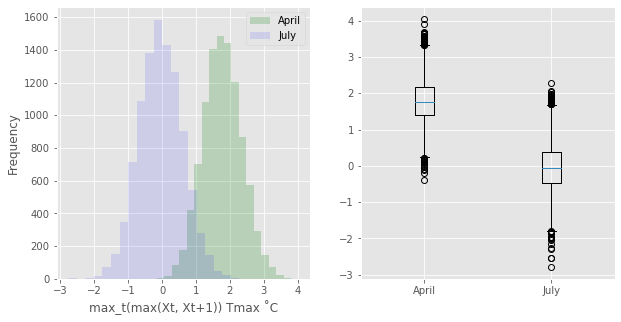

In [1197]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].hist(maxi_2d, bins=20, alpha=0.2, color='green', label='April')
ax[0].hist(maxi_2d_july, bins=20, alpha=0.1, color='blue', label='July')
ax[0].set_xlabel('max_t(max(Xt, Xt+1)) Tmax ˚C')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[1].boxplot( np.concatenate([maxi_2d, maxi_2d_july], axis=1), labels=['April', 'July'])
plt.show()

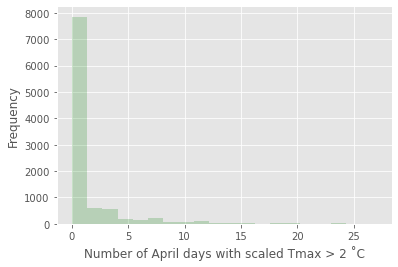

In [1199]:
## Calculate a different reading --- number of days with scaled Tmax > 2 ˚C in April
readout = np.sum(Z[:, 15:45] > 2, 1)
plt.hist(readout, bins=20, alpha=0.2, color='green')
plt.xlabel('Number of April days with scaled Tmax > 2 ˚C')
plt.ylabel('Frequency')
plt.show()


In [1205]:
np.mean(Z[:, 15:45], 1).shape

(10000,)

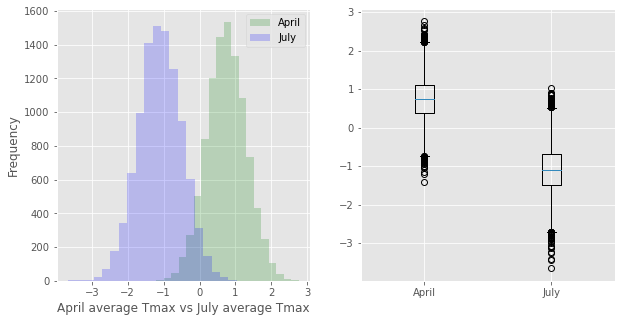

In [1210]:
## Calculate a different reading --- April average Tmax vs July average Tmax
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

readout_m_april = np.mean(Z[:, 15:45], 1)
readout_m_july = np.mean(Z[:, 124:154], 1)

ax[0].hist(readout_m_april, bins=20, alpha=0.2, color='green', label='April')
ax[0].hist(readout_m_july, bins=20, alpha=0.2, color='blue', label='July')
ax[0].set_xlabel('April average Tmax vs July average Tmax')
ax[0].set_ylabel('Frequency')
ax[1].boxplot( np.concatenate([readout_m_april.reshape(-1, 1), readout_m_july.reshape(-1, 1)], axis=1), labels=['April', 'July'])
ax[0].legend()

plt.show()

In [ ]:
#### Check same readings for first 7-days vs last 7-days in the generated 180 days

In [1211]:
start_ix = 0
consec_days = np.concatenate([np.arange(start_ix, start_ix + 7, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 7, 1) + 1).reshape(-1, 1)], axis=1)
maxi_2d = [np.max(np.max(Z[np.repeat(i, consec_days.shape[0]).reshape(-1, 1), consec_days], axis=1)) for i in range(num_samples)]
maxi_2d = np.array(maxi_2d).reshape(-1, 1)

In [1213]:
start_ix = 172
consec_days_j = np.concatenate([np.arange(start_ix, start_ix +7, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 7, 1) + 1).reshape(-1, 1)], axis=1)
maxi_2d_july = [np.max(np.max(Z[np.repeat(i, consec_days_j.shape[0]).reshape(-1, 1), consec_days_j], axis=1)) for i in range(num_samples)]
maxi_2d_july = np.array(maxi_2d_july).reshape(-1, 1)

In [1264]:
start_ix = 172
consec_days_j = np.concatenate([np.arange(start_ix, start_ix +7, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 7, 1) + 1).reshape(-1, 1)], axis=1)
maxi_2d_july = [Z[np.repeat(i, consec_days_j.shape[0]).reshape(-1, 1), consec_days_j] for i in range(num_samples)]
maxi_2d_july = np.array(maxi_2d_july)

In [1273]:
start_ix = 0
consec_days_j = np.concatenate([np.arange(start_ix, start_ix +7, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 7, 1) + 1).reshape(-1, 1)], axis=1)
maxi_2d = [Z[np.repeat(i, consec_days_j.shape[0]).reshape(-1, 1), consec_days_j] for i in range(num_samples)]
maxi_2d = np.array(maxi_2d)

(array([[0.000e+00, 0.000e+00, 5.000e+00, 1.100e+01, 6.000e+00, 4.000e+00,
         1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [3.000e+00, 1.300e+01, 4.000e+01, 7.300e+01, 8.500e+01, 4.200e+01,
         1.400e+01, 1.000e+00, 0.000e+00, 0.000e+00],
        [6.000e+00, 4.600e+01, 2.140e+02, 5.400e+02, 6.700e+02, 4.330e+02,
         1.280e+02, 3.500e+01, 0.000e+00, 0.000e+00],
        [1.000e+01, 1.050e+02, 6.160e+02, 1.742e+03, 2.763e+03, 2.126e+03,
         9.100e+02, 1.730e+02, 1.800e+01, 0.000e+00],
        [1.500e+01, 1.340e+02, 9.280e+02, 3.234e+03, 5.804e+03, 5.345e+03,
         2.443e+03, 5.740e+02, 6.300e+01, 1.000e+00],
        [8.000e+00, 7.500e+01, 7.220e+02, 3.054e+03, 6.429e+03, 6.958e+03,
         3.568e+03, 9.160e+02, 1.200e+02, 3.000e+00],
        [1.000e+00, 2.800e+01, 2.790e+02, 1.482e+03, 3.638e+03, 4.391e+03,
         2.802e+03, 8.040e+02, 1.280e+02, 1.100e+01],
        [0.000e+00, 9.000e+00, 7.400e+01, 3.450e+02, 1.062e+03, 1.494e+03,
         9.440e+02, 3.

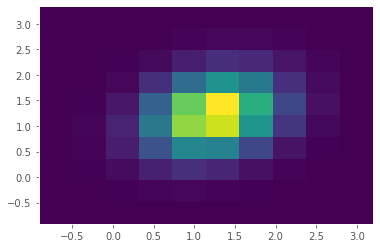

In [1274]:
plt.hist2d(x = maxi_2d.reshape(-1, 2)[:, 0], y=maxi_2d.reshape(-1, 2)[:, 1])

(array([[3.000e+00, 1.000e+01, 2.400e+01, 5.000e+00, 2.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [7.000e+00, 7.800e+01, 2.180e+02, 1.970e+02, 5.500e+01, 5.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [9.000e+00, 1.260e+02, 8.920e+02, 1.560e+03, 8.730e+02, 1.340e+02,
         5.000e+00, 1.000e+00, 0.000e+00, 0.000e+00],
        [1.000e+00, 1.050e+02, 1.132e+03, 4.245e+03, 4.822e+03, 1.786e+03,
         2.150e+02, 4.000e+00, 0.000e+00, 0.000e+00],
        [0.000e+00, 1.100e+01, 4.490e+02, 3.732e+03, 8.957e+03, 6.873e+03,
         1.576e+03, 1.120e+02, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, 6.800e+01, 1.041e+03, 5.497e+03, 8.351e+03,
         4.087e+03, 6.070e+02, 2.500e+01, 0.000e+00],
        [0.000e+00, 0.000e+00, 3.000e+00, 1.030e+02, 1.038e+03, 3.474e+03,
         3.588e+03, 1.127e+03, 1.040e+02, 2.000e+00],
        [0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 6.400e+01, 4.550e+02,
         1.021e+03, 6.

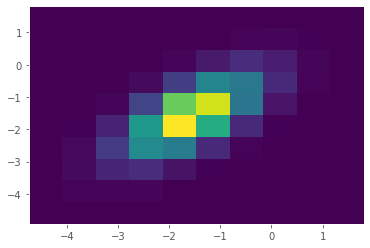

In [1272]:
plt.hist2d(x = maxi_2d_july.reshape(-1, 2)[:, 0], y=maxi_2d_july.reshape(-1, 2)[:, 1])

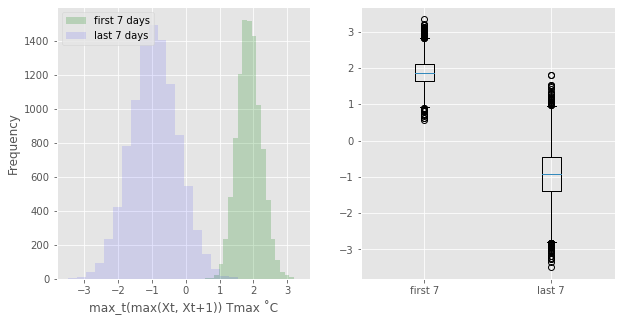

In [1216]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].hist(maxi_2d, bins=20, alpha=0.2, color='green', label='first 7 days')
ax[0].hist(maxi_2d_july, bins=20, alpha=0.1, color='blue', label='last 7 days')
ax[0].set_xlabel('max_t(max(Xt, Xt+1)) Tmax ˚C')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[1].boxplot( np.concatenate([maxi_2d, maxi_2d_july], axis=1), labels=['first 7', 'last 7'])
plt.show()

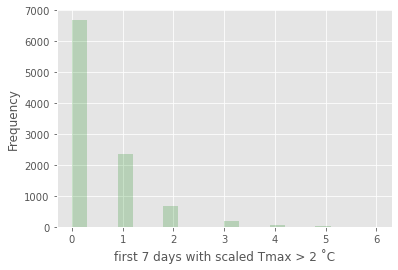

In [1258]:
## Calculate a different reading --- number of days with scaled Tmax > 2 ˚C in April
readout = np.sum(Z[:, :7] > 2, 1)
plt.hist(readout, bins=20, alpha=0.2, color='green')
plt.xlabel('first 7 days with scaled Tmax > 2 ˚C')
plt.ylabel('Frequency')
plt.show()

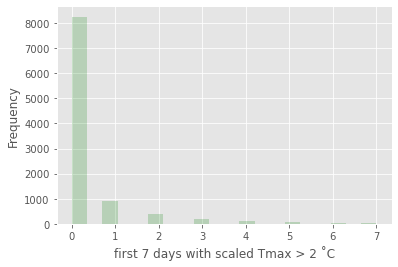

In [1257]:
readout = np.sum(Z[:, 24:31] > 2, 1)
plt.hist(readout, bins=20, alpha=0.2, color='green')
plt.xlabel('first 7 days with scaled Tmax > 2 ˚C')
plt.ylabel('Frequency')
plt.show()

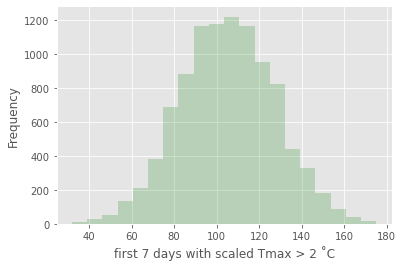

In [1287]:
readout = np.sum(Z[:, :] > -0.5, 1)
plt.hist(readout, bins=20, alpha=0.2, color='green')
plt.xlabel('first 7 days with scaled Tmax > 2 ˚C')
plt.ylabel('Frequency')
plt.show()

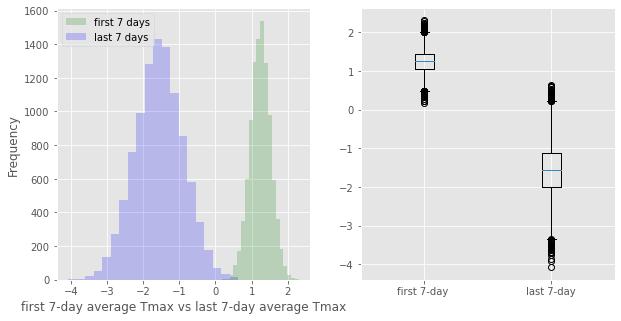

In [1219]:
## Calculate a different reading --- April average Tmax vs July average Tmax
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

readout_m_april = np.mean(Z[:, :7], 1)
readout_m_july = np.mean(Z[:, 172:], 1)

ax[0].hist(readout_m_april, bins=20, alpha=0.2, color='green', label='first 7 days')
ax[0].hist(readout_m_july, bins=20, alpha=0.2, color='blue', label='last 7 days')
ax[0].set_xlabel('first 7-day average Tmax vs last 7-day average Tmax')
ax[0].set_ylabel('Frequency')
ax[1].boxplot( np.concatenate([readout_m_april.reshape(-1, 1), readout_m_july.reshape(-1, 1)], axis=1), labels=['first 7-day ', 'last 7-day'])
ax[0].legend()

plt.show()

In [1223]:
readout_m_7_day[0].shape

(10000,)

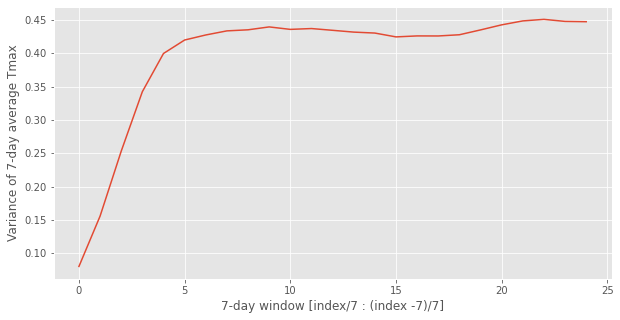

In [1232]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

readout_m_7_day = [np.mean(Z[:, 7*i:7*(i+1)], 1) for i in range(25)]

ax.plot(np.arange(25), np.var(np.array(readout_m_7_day), 1))
ax.set_xlabel('7-day window [index/7 : (index -7)/7]')
ax.set_ylabel('Variance of 7-day average Tmax')
plt.show()

In [1234]:
    start_ix = 10
    consec_days = np.concatenate([np.arange(start_ix, start_ix + 7, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 7, 1) + 1).reshape(-1, 1)], axis=1)
    maxi_2d = [np.max(np.max(Z[np.repeat(i, consec_days.shape[0]).reshape(-1, 1), consec_days], axis=1)) for i in range(num_samples)]
    maxi_2d = np.array(maxi_2d).reshape(-1, 1)
    maxi_2d.shape

(10000, 1)

In [1242]:
var_maxi = []
for i in range(0, 173, 7):
    start_ix = i
    consec_days = np.concatenate([np.arange(start_ix, start_ix + 7, 1).reshape(-1, 1), (np.arange(start_ix, start_ix + 7, 1) + 1).reshape(-1, 1)], axis=1)
    maxi_2d = [np.max(np.max(Z[np.repeat(i, consec_days.shape[0]).reshape(-1, 1), consec_days], axis=1)) for i in range(num_samples)]
    maxi_2d = np.array(maxi_2d).reshape(-1, 1)
    var_maxi.append(np.var(maxi_2d))




In [ ]:
# Dont need to specify what prob. model we use under the hood
# put toy examples in development of the system 
# Evaluation - key pieces of evidence that existing stuff is crammy
# 15 pages of text for each contribution including what usually goes to appendix
# take data that isnt paired -- gives silly answers 




### Dumb GP

In [879]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t < 1989) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
x_tr, y_tr = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180, batch_size=5000, abs_t = True)

In [880]:
x2 = np.concatenate([np.zeros((180, 1)), np.ones((180, 1))], axis=0)[np.newaxis, :, :]
x2 = np.repeat(x2, 5000, axis=0)
x_tr = np.concatenate([x_tr, x2], axis=-1)

In [881]:
# linear kernel is   k(x, y) = σ²xy
k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) + gpflow.kernels.White(0.0005)


In [882]:
# Define full kernel
k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) + gpflow.kernels.White(0.0005)

###########################################################################
# Parameter bounds (otherwise the optimization might go crazy)

k1.kernels[0].variance  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(100),
    ),)
k1.kernels[0].lengthscales  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(20),
    ),)
k1.kernels[1].kernels[1].variance  = gpflow.Parameter(
0.5,
transform=tfp.bijectors.SoftClip(
    gpflow.utilities.to_default_float(0.0001),
    gpflow.utilities.to_default_float(20),
),)
k1.kernels[1].kernels[1].lengthscales  = gpflow.Parameter(
0.5,
transform=tfp.bijectors.SoftClip(
    gpflow.utilities.to_default_float(0.0001),
    gpflow.utilities.to_default_float(20),
),)
k1.kernels[2].variance  = gpflow.Parameter(
0.5,
transform=tfp.bijectors.SoftClip(
    gpflow.utilities.to_default_float(0.0001),
    gpflow.utilities.to_default_float(1),
),)
###########################################################################

# init model
gp_model = gpflow.models.GPR((x_tr[0, :, :], y_tr[0, :].reshape(-1, 1)),  kernel=k1)
# keep the WN fixed otherwise optimisation fails
set_trainable(gp_model.kernel.kernels[3].variance , False)
set_trainable(gp_model.kernel.kernels[1].kernels[0].variance  , False)

In [883]:
# Train the model for 5000 sequences (each of length 360)
opt = gpflow.optimizers.Scipy()
idxs = np.arange(5000)
for i in idxs:
    if ((i-1) % 100 == 0) & (i > 1):
        print(i)
        print_summary(gp_model)
    gp_model = gpflow.models.GPR((x_tr[i, :, :], y_tr[i, :].reshape(-1, 1)),  kernel=k1)
    opt.minimize(gp_model.training_loss, gp_model.trainable_variables)
    if (i % 100 == 0) & (i > 0):
        IPython.display.clear_output(wait=True)
        print(i)
        print_summary(gp_model)

2023-06-05 15:33:12.820801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:33:13.962658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:33:14.842533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:33:15.775586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:33:16.582509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:33:17.438895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:33:18.321380: I tensorflow/core/grappler/optimizers/cust

KeyboardInterrupt: 

#### Testing

In [884]:
array

,grid_val,loc_key,t,lat,lon,year,month,day,tmax,tmax_mu,...,axis_nbounds,height,tasmax,year_gcm,month_gcm,day_gcm,run,tasmax_mu,tasmax_sigma,gcm_adj_tasmax
0,11,0,1948.000000,4.76184,7.50,1948.0,1.0,1.0,24.45000,24.978251,...,0.0,2.0,28.334184,1948.0,1.0,1.0,15.5,27.508003,1.686392,0.489910
1,11,0,1948.002688,4.76184,7.50,1948.0,1.0,2.0,24.17498,24.978251,...,0.0,2.0,28.682093,1948.0,1.0,2.0,15.5,27.508003,1.686392,0.696214
2,11,0,1948.005376,4.76184,7.50,1948.0,1.0,3.0,24.67500,24.978251,...,0.0,2.0,28.568930,1948.0,1.0,3.0,15.5,27.508003,1.686392,0.629111
3,11,0,1948.008065,4.76184,7.50,1948.0,1.0,4.0,24.80000,24.978251,...,0.0,2.0,28.746881,1948.0,1.0,4.0,15.5,27.508003,1.686392,0.734632
4,11,0,1948.010753,4.76184,7.50,1948.0,1.0,5.0,25.40000,24.978251,...,0.0,2.0,28.801951,1948.0,1.0,5.0,15.5,27.508003,1.686392,0.767287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464963,24,15,2014.991935,10.47604,11.25,2014.0,12.0,29.0,26.70000,28.397762,...,0.0,2.0,27.083563,2014.0,12.0,29.0,15.5,31.727749,2.602508,-1.784504
464964,24,15,2014.994624,10.47604,11.25,2014.0,12.0,30.0,27.85000,28.397762,...,0.0,2.0,28.272075,2014.0,12.0,30.0,15.5,30.253285,2.102290,-0.942405
464965,24,15,2014.994624,10.47604,11.25,2014.0,12.0,30.0,27.85000,28.397762,...,0.0,2.0,27.055268,2014.0,12.0,30.0,15.5,31.727749,2.602508,-1.795376
464966,24,15,2014.997312,10.47604,11.25,2014.0,12.0,31.0,28.15000,28.397762,...,0.0,2.0,28.131570,2014.0,12.0,31.0,15.5,30.253285,2.102290,-1.009240


In [885]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t >= 1988) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)

In [886]:
arr_temp

,t,gcm_adj_tasmax,era_adj_tmax
0,1988.000000,0.000329,1.160815
1,1988.002688,0.007022,0.939683
2,1988.005376,-0.018582,0.858609
3,1988.008065,-0.000377,1.639917
4,1988.010753,0.076319,0.792265
...,...,...,...
9857,2014.986559,0.256129,-0.364957
9858,2014.989247,0.210290,0.077296
9859,2014.991935,0.139222,0.180494
9860,2014.994624,0.158199,0.327906


In [887]:
y_te = np.concatenate([np.array(arr_temp.iloc[280:640, 1]), np.array(arr_temp.iloc[280:640, 2])], axis=0)[np.newaxis, :]
x_te = np.concatenate([np.array(arr_temp.iloc[280:640, 0] ), np.array(arr_temp.iloc[280:640, 0] )], axis=0)[np.newaxis, :, np.newaxis]
# uncomment to use relative time and comment out the previous line
# x_te = np.concatenate([np.linspace(1,2,180), np.linspace(1,2,180)], axis=0)[np.newaxis, :, np.newaxis] 
x_te = np.concatenate([x_te, np.concatenate([np.zeros((360, 1)), np.ones((360, 1))], axis=0)[np.newaxis, :, :]], axis=-1)


In [888]:
Σ_aa = k1(x_te[0, :, :])[540:, 540:]   
Σ_ab = k1(x_te[0, :, :])[540:, :540]  
Σ_ba = k1(x_te[0, :, :])[:540, 540:]  
Σ_bb = k1(x_te[0, :, :])[:540, :540]     

In [889]:
mk, vk = gp_model.predict_y(x_te[0, :, :])

In [890]:
print_summary(k1)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ Sum.kernels[0].variance                │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 0.594994   │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 0.0376185  │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ False       │ ()      │ float64 │ 1    

In [891]:
x_te[0, :540]

array([[1.98876613e+03, 0.00000000e+00],
       [1.98876882e+03, 0.00000000e+00],
       [1.98877151e+03, 0.00000000e+00],
       ...,
       [1.98925269e+03, 1.00000000e+00],
       [1.98925538e+03, 1.00000000e+00],
       [1.98925806e+03, 1.00000000e+00]])

In [892]:
μ_a_g_b = Σ_ab @ np.linalg.inv(Σ_bb) @ ((y_te[0, :540]).reshape(-1, 1))
Σ_a_g_b = Σ_aa - Σ_ab @ np.linalg.inv(Σ_bb) @ Σ_ba
sigma = np.diag(Σ_a_g_b)

In [893]:
np.argsort(sigma)

array([  0,   1,   2,   3,   4,   5,   6,   7,  36,  47,  15,  76, 118,
        66,  64, 109, 119,  97, 108,  56,  55,  48, 121,  57,  37,  46,
        49, 107, 116,  65, 110, 106,  54, 117,  59,  45, 120,  52,  50,
        53,  77,  75,  98, 115, 111,  63, 123,  58,  61, 122, 112,  96,
       127,  67, 114, 125,  16, 113,  62,  14, 124, 126,  51,  60, 129,
       130,  35,  44, 128, 131,  68, 132, 105, 135, 133,  13, 134,   8,
       136,  99,  74,  38,  69, 104,  43, 137,  42,  73, 100,  12, 138,
        39,   9, 103,  70,  41, 139, 102,  40,  72, 101,  10,  11, 140,
        71,  17,  34,  95,  78, 141, 142, 143, 144, 145, 146, 147, 148,
        79, 149,  33,  18,  94, 150, 151, 152, 153, 154, 155, 156,  32,
        80,  93,  19, 157, 158, 159,  20,  92,  81,  31, 160, 161,  82,
        30,  91,  21, 162, 163, 164, 165,  90,  29,  83,  22, 166, 167,
        23,  89,  84,  28,  24,  27,  88,  85, 168,  25,  86,  26,  87,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179])

In [894]:
x_te[0, 540:720, 0]

array([1989.26075269, 1989.26344086, 1989.26612903, 1989.2688172 ,
       1989.27150538, 1989.27419355, 1989.27688172, 1989.27956989,
       1989.28225806, 1989.28494624, 1989.28763441, 1989.29032258,
       1989.29301075, 1989.29569892, 1989.2983871 , 1989.30107527,
       1989.30376344, 1989.30645161, 1989.30913978, 1989.31182796,
       1989.31451613, 1989.3172043 , 1989.31989247, 1989.32258065,
       1989.32526882, 1989.32795699, 1989.33333333, 1989.33602151,
       1989.33870968, 1989.34139785, 1989.34408602, 1989.34677419,
       1989.34946237, 1989.35215054, 1989.35483871, 1989.35752688,
       1989.36021505, 1989.36290323, 1989.3655914 , 1989.36827957,
       1989.37096774, 1989.37365591, 1989.37634409, 1989.37903226,
       1989.38172043, 1989.3844086 , 1989.38709677, 1989.38978495,
       1989.39247312, 1989.39516129, 1989.39784946, 1989.40053763,
       1989.40322581, 1989.40591398, 1989.40860215, 1989.41129032,
       1989.41397849, 1989.41666667, 1989.41935484, 1989.42204

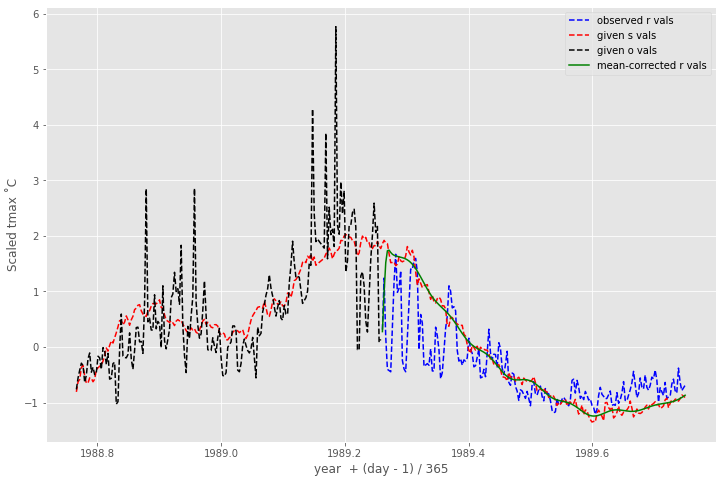

In [895]:
plt.figure(figsize=(12, 8))
plt.plot(x_te[0, 540:720, 0].reshape(-1, 1), y_te[0, 540:720].reshape(-1, 1), '--', c='blue', label = 'observed r vals')
plt.plot(x_te[0, :360, 0].reshape(-1, 1), y_te[0, :360].reshape(-1, 1), '--', c='red', label = 'given s vals')
plt.plot(x_te[0, 360:540, 0].reshape(-1, 1), y_te[0, 360:540].reshape(-1, 1), '--', c='black', label = 'given o vals')
plt.plot(x_te[0, 540:720, 0], μ_a_g_b, c='green', label= 'mean-corrected r vals')

# plt.plot(x_te[0, :360, 0].reshape(-1, 1), mk[:360, 0], c='gray', label= 'mean-corrected r vals', alpha=0.4)
# plt.plot(x_te[0, 360:540, 0].reshape(-1, 1), mk[360:540, 0], c='gray', label= 'mean-corrected r vals', alpha=0.4)

# plt.fill_between(
#     x_te[0, 540:720, 0],
#     (μ_a_g_b - 2 * np.sqrt(sigma))[:, 0],
#     (μ_a_g_b + 2 * np.sqrt(sigma))[:, 0],
#     color='lightblue',
#     alpha=0.4,
# )
# plt.xlabel('(Days since seq. start / 180) + 1')
plt.xlabel('year  + (day - 1) / 365')
plt.ylabel('Scaled tmax ˚C')
plt.legend()
plt.show()

### Better GP

In [755]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t < 1989) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)
x_tr, y_tr = batcher.batcher_bc(np.array(arr_temp.reset_index(drop=True)), 180, batch_size=5000, abs_t=True)

In [756]:
x2 = np.concatenate([np.zeros((180, 1)), np.ones((180, 1))], axis=0)[np.newaxis, :, :]
x2 = np.repeat(x2, 5000, axis=0)
x_tr = np.concatenate([x_tr, x2], axis=-1)

In [757]:
x_tr_share = np.zeros([10000, 180])
y_tr_share = np.zeros([10000, 180])

In [758]:
x_tr_share[::2, :] = x_tr[:, :180, 0]
x_tr_share[1::2, :] = x_tr[:, 180:, 0]
y_tr_share[::2, :] = y_tr[:, :180]
y_tr_share[1::2, :] = y_tr[:, 180:]

#### Shared RBF kernel

In [759]:
# Train first a model with a shared RBF 
k_shared = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) + gpflow.kernels.White(0.0005)
# Parameter bounds (otherwise the optimization might go crazy)
k_shared.kernels[0].variance  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(100),
    ),)
k_shared.kernels[0].lengthscales  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(100),
    ),)


In [760]:
gp_model = gpflow.models.GPR((x_tr_share[0, :], y_tr_share[0, :].reshape(-1, 1)),  kernel=k_shared)

In [761]:
# keep the WN fixed otherwise optimisation fails
set_trainable(gp_model.kernel.kernels[1].variance , False)

#### Trainig

In [762]:
# Train the model for 5000 sequences (each of length 360)
opt = gpflow.optimizers.Scipy()
idxs = np.arange(10000)
for i in idxs:
    if ((i-1) % 100 == 0) & (i > 1):
        print(i)
        print_summary(gp_model)
    # gp_model = gpflow.models.GPR((x_tr[i, :, :], y_tr[i, :].reshape(-1, 1)),  kernel=k1)
    gp_model = gpflow.models.GPR((x_tr_share[i, :].reshape(-1, 1), y_tr_share[i, :].reshape(-1, 1)),  kernel=k_shared)
    opt.minimize(gp_model.training_loss, gp_model.trainable_variables)
    if (i % 100 == 0) & (i > 0):
        IPython.display.clear_output(wait=True)
        print(i)
        print_summary(gp_model)




1600
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │      value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ SoftClip         │         │ True        │ ()      │ float64 │ 1.03249    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ SoftClip         │         │ True        │ ()      │ float64 │ 0.0305699  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ fl

2023-06-05 15:19:28.155045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:19:28.566234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:19:29.148428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:19:29.600750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:19:30.007963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:19:30.495497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 15:19:30.914151: I tensorflow/core/grappler/optimizers/cust

KeyboardInterrupt: 

In [587]:
# Define full kernel
k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) + gpflow.kernels.White(0.0005)
# init model
gp_model = gpflow.models.GPR((x_tr[0, :, :], y_tr[0, :].reshape(-1, 1)),  kernel=k1)


#### Per - sequence training

In [588]:
# Train the model with global RBF params fixed and local RBF params changing per seq. (each of length 360)
opt = gpflow.optimizers.Scipy()
params = []
idxs = np.arange(5000)
for i in idxs:
    ### Reset the model
    k1 = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1)  + gpflow.kernels.White(0.005)

    ### init model
    gp_model = gpflow.models.GPR((x_tr[0, :, :], y_tr[0, :].reshape(-1, 1)),  kernel=k1)
    
    ### Set the shared RBF params
    gp_model.kernel.kernels[0].variance.assign(k_shared.kernels[0].variance)
    gp_model.kernel.kernels[0].lengthscales.assign(k_shared.kernels[0].lengthscales) 
    set_trainable(gp_model.kernel.kernels[0].variance , False)
    set_trainable(gp_model.kernel.kernels[0].lengthscales, False)
    set_trainable(gp_model.kernel.kernels[2].variance, False)

    ### Set the local RBF params boundaries
    k1.kernels[1].kernels[0].variance  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(10),
    ),)
    k1.kernels[1].kernels[1].variance  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(10),
    ),)
    k1.kernels[1].kernels[1].lengthscales  = gpflow.Parameter(
    0.5,
    transform=tfp.bijectors.SoftClip(
        gpflow.utilities.to_default_float(0.0001),
        gpflow.utilities.to_default_float(10),
    ),)

    if ((i-1) % 100 == 0) & (i > 1):
        print(i)
        print_summary(gp_model)
    
    gp_model = gpflow.models.GPR((x_tr[i, :, :], y_tr[i, :].reshape(-1, 1)),  kernel=k1)
    opt.minimize(gp_model.training_loss, gp_model.trainable_variables)
    
    ### collect params to list
    params.append([gp_model.kernel.kernels[0].lengthscales.numpy(), 
                   gp_model.kernel.kernels[0].variance.numpy(),
                     gp_model.kernel.kernels[1].kernels[0].variance.numpy(),
                        gp_model.kernel.kernels[1].kernels[1].variance.numpy(),
                        gp_model.kernel.kernels[1].kernels[1].lengthscales.numpy(),
                            gp_model.kernel.kernels[2].variance.numpy()])

    if (i % 100 == 0) & (i > 0):
        IPython.display.clear_output(wait=True)
        print(i)
        print_summary(gp_model)

2023-06-05 12:02:40.472306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 12:02:41.178258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 12:02:41.915543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 12:02:42.956526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 12:02:43.850787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 12:02:44.993326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 12:02:45.786887: I tensorflow/core/grappler/optimizers/cust

KeyboardInterrupt: 

#### Testing

In [590]:
r_grid_val = np.random.choice(np.unique(array.grid_val), 1)[0]
r_loc_key = np.random.choice(np.unique(array.loc[array.grid_val==r_grid_val, ['loc_key_gcm']]), 1)[0]
arr_temp = array.loc[(array.t >= 1988) & (array.grid_val==r_grid_val) & (array.loc_key_gcm == r_loc_key), ['t', 'gcm_adj_tasmax', 'era_adj_tmax']].reset_index(drop=True)

In [591]:
y_te = np.concatenate([np.array(arr_temp.iloc[280:640, 1]), np.array(arr_temp.iloc[280:640, 2])], axis=0)[np.newaxis, :]
x_te = np.concatenate([np.array(arr_temp.iloc[280:640, 0] ), np.array(arr_temp.iloc[280:640, 0] )], axis=0)[np.newaxis, :, np.newaxis]
# uncomment to use relative time and comment out the previous line
# x_te = np.concatenate([np.linspace(1,2,180), np.linspace(1,2,180)], axis=0)[np.newaxis, :, np.newaxis] 
x_te = np.concatenate([x_te, np.concatenate([np.zeros((360, 1)), np.ones((360, 1))], axis=0)[np.newaxis, :, :]], axis=-1)

In [599]:
print_summary(k_shared)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ Sum.kernels[0].variance     │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 1.47302  │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 0.176423 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ False       │ ()      │ float64 │ 0.0005   │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════

In [598]:
print_summary(k1)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ Sum.kernels[0].variance                │ Parameter │ Softplus    │         │ False       │ ()      │ float64 │ 1.47302   │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ Softplus    │         │ False       │ ()      │ float64 │ 0.176423  │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ SoftClip    │         │ True        │ ()      │ float64 │ 0.469578  │


In [592]:
Σ_aa = k1(x_te[0, :, :])[540:, 540:]   
Σ_ab = k1(x_te[0, :, :])[540:, :540]  
Σ_ba = k1(x_te[0, :, :])[:540, 540:]  
Σ_bb = k1(x_te[0, :, :])[:540, :540]   

In [593]:
mk, vk = gp_model.predict_y(x_te[0, :, :])

In [596]:
μ_a_g_b = Σ_ab @ np.linalg.inv(Σ_bb) @ ((y_te[0, :540]).reshape(-1, 1))
Σ_a_g_b = Σ_aa - Σ_ab @ np.linalg.inv(Σ_bb) @ Σ_ba
sigma = np.sqrt(np.diag(Σ_a_g_b))

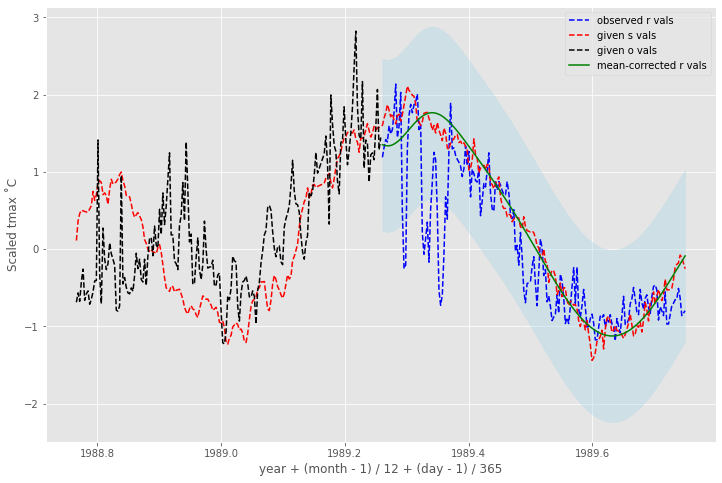

In [597]:
plt.figure(figsize=(12, 8))
plt.plot(x_te[0, -180:, 0].reshape(-1, 1), y_te[0, -180:].reshape(-1, 1), '--', c='blue', label = 'observed r vals')
plt.plot(x_te[0, :360, 0].reshape(-1, 1), y_te[0, :360].reshape(-1, 1), '--', c='red', label = 'given s vals')
plt.plot(x_te[0, 360:540, 0].reshape(-1, 1), y_te[0, 360:540].reshape(-1, 1), '--', c='black', label = 'given o vals')
plt.plot(x_te[0, -180:, 0], μ_a_g_b, c='green', label= 'mean-corrected r vals')


plt.plot(x_te[0, :360, 0].reshape(-1, 1), mk[:360, 0], c='gray', label= 'mean-corrected r vals', alpha=0.4)
plt.plot(x_te[0, 360:540, 0].reshape(-1, 1), mk[360:540, 0], c='gray', label= 'mean-corrected r vals', alpha=0.4)


plt.fill_between(
    x_te[0, -180:, 0],
    (μ_a_g_b - 2 * np.sqrt(sigma))[:, 0],
    (μ_a_g_b + 2 * np.sqrt(sigma))[:, 0],
    color='lightblue',
    alpha=0.4,
)
# plt.xlabel('(Days since seq. start / 180) + 1')
plt.xlabel('year + (month - 1) / 12 + (day - 1) / 365')
plt.ylabel('Scaled tmax ˚C')
plt.legend()
plt.show()

### Example for generated data from kernel and trainnig 

In [733]:
k_trial = gpflow.kernels.RBF(active_dims=[0], lengthscales=1, variance=1) +  gpflow.kernels.Linear(active_dims=[1], variance=1) * gpflow.kernels.RBF(active_dims=[0], lengthscales=0.6, variance=1) + gpflow.kernels.White(0.05) + gpflow.kernels.White(0.0005)


In [734]:
T = 100
t = np.concatenate([np.linspace(5,15,T//2), np.linspace(5,15,T-T//2)])


In [735]:
xa = np.concatenate((t.reshape(-1, 1),  np.zeros((100, 1)).reshape(-1, 1)), axis=-1) 
xa[50:, 1] =  1 

In [736]:
Z = np.random.multivariate_normal(np.zeros(100), k_trial(xa), 1)


In [737]:
y = np.concatenate((Z[0, :50].reshape(1, -1),  Z[0, 50:].reshape(1, -1)), axis=-1)

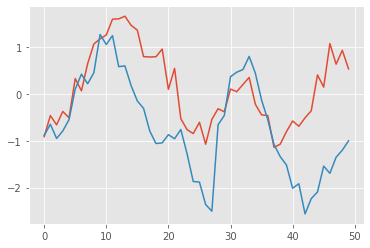

In [738]:
plt.plot(Z.transpose()[:50])

plt.plot(Z.transpose()[50:])

In [739]:
m_n = gpflow.models.GPR((xa[:70, :].reshape(70, -1), y[0, :70].reshape(-1, 1)),  kernel=k_trial)

In [740]:
set_trainable(gp_model.kernel.kernels[1].kernels[0].variance , False)

In [742]:
gpflow.optimizers.Scipy().minimize(
    m_n.training_loss, m_n.trainable_variables)

2023-06-05 14:59:58.398255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


      fun: 24.45461973942554
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.01549937e-05, -7.33941331e-05,  1.35869150e-05, -1.10428399e-04,
        1.35869150e-05,  1.55144087e-05,  1.80651638e-07,  2.94820798e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([ 0.45113703, -0.05043813,  0.46147205,  1.17796242,  0.46147205,
       -3.10458113, -7.60090211, -4.80083042])

In [743]:
mk1, vk1 = m_n.predict_y(xa[:, :])

In [745]:
Σ_aa = k_trial(xa)[70:, 70:]   
Σ_ab = k_trial(xa)[70:, :70]  
Σ_ba = k_trial(xa)[:70, 70:]  
Σ_bb = k_trial(xa)[:70, :70]   

In [746]:
μ_a_g_b =  Σ_ab @ np.linalg.inv(Σ_bb) @ ((y[0, :70]).reshape(-1, 1) ) # analytical calc. of mean should be equal to mk1[70:]
Σ_a_g_b = Σ_aa - Σ_ab @ np.linalg.inv(Σ_bb) @ Σ_ba

In [752]:
mk1[:50, 0].shape

TensorShape([50])

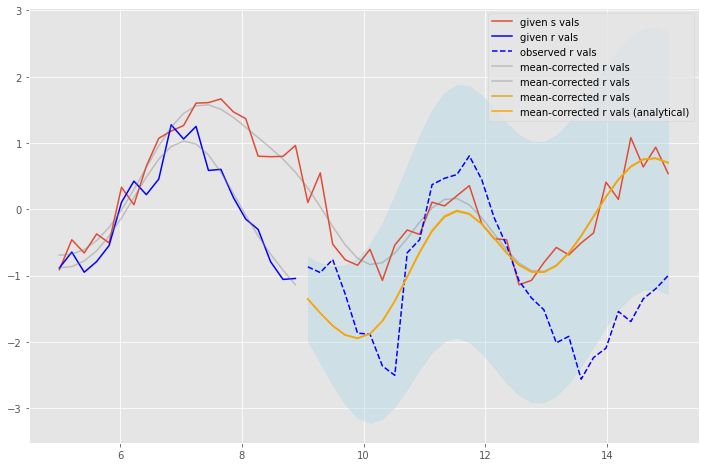

In [754]:
plt.figure(figsize=(12, 8))
plt.plot(t[:50].reshape(-1, 1), y[0,:50].reshape(-1, 1), label = 'given s vals')
plt.plot(t[50:70].reshape(-1, 1), y[0,50:70].reshape(-1, 1), c='blue', label = 'given r vals')
plt.plot(t[70:].reshape(-1, 1), y[0,70:].reshape(-1, 1), '--', c='blue', label = 'observed r vals')


plt.plot(t[:50], mk1[:50, 0], c='gray', label= 'mean-corrected r vals', alpha=0.4)
plt.plot(t[50:70], mk1[50:70, 0], c='gray', label= 'mean-corrected r vals', alpha=0.4)

plt.plot(t[70:], mk1[70:, 0], c='goldenrod', label= 'mean-corrected r vals')
plt.plot(t[70:], μ_a_g_b[:, 0], c='orange', label= 'mean-corrected r vals (analytical)')

plt.fill_between(
    t[70:],
    (mk1[70:, 0]- 2 * np.sqrt(vk1[70:, 0])),
    (mk1[70:, 0] + 2 * np.sqrt(vk1[70:, 0])),
    color='lightblue',
    alpha=0.4,
)

plt.legend()
plt.show()

In [750]:
print_summary(k_trial)

╒════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                   │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ Sum.kernels[0].variance                │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.668246    │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ Sum.kernels[0].lengthscales            │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.943943    │
├────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ Sum.kernels[1].kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 

In [54]:
mu = 2
sigma = 1
delta = 1.3

x = np.random.normal(mu, sigma, 100000)
y = np.random.normal(mu + delta, sigma, 100000)

In [55]:
np.mean(y - x)

1.3056932943319097

In [58]:
mu = 2
sigma = 1
delta = 1.3

x = np.random.normal(mu, sigma, 100000)
x_pair = x + delta
y = np.random.choice(x_pair, 100000)

In [59]:
np.mean(y - x)

1.2984209984206738

In [79]:
mu = 2
sigma = 1
delta = 1.3

x = np.random.normal(mu, sigma, 100000)
y = np.random.normal(mu + delta, sigma - 0.6, 100000)

In [80]:
np.std(y - x)

1.076419545390864

In [81]:
mu = 2
sigma = 1
delta = np.random.normal(1.3, 0.6, 100000)

x = np.random.normal(mu, sigma, 100000)
y = x + delta
y1  = np.random.choice(y, 100000)

In [82]:
np.mean(y1 - x)

1.2983616523177022

In [85]:
np.std(y1 - x)

1.5404815710029285

In [87]:
mu = 2
sigma = 1
B = np.random.normal(1.3, 0.6, 100000)

x = np.random.normal(mu, sigma, 100000)
y = B * x 
print(np.mean(y/x))

y1  = np.random.choice(y, 100000)
print(np.mean(y1/x))

1.2993855651149329
3.631874176644072


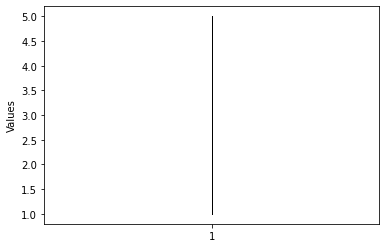

In [1]:
import matplotlib.pyplot as plt

# Sample data
data = [1, 2, 3, 4, 5]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a boxplot with zero width boxes
boxplot = ax.boxplot(data, widths=0)

# Hide the outliers
for flier in boxplot["fliers"]:
    flier.set(marker="", color="none")

# Set y-axis label
ax.set_ylabel("Values")

# Show the plot
plt.show()

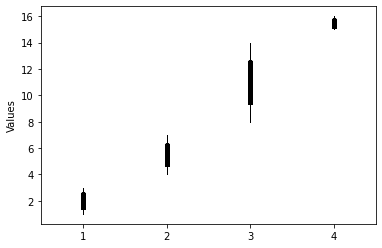

In [2]:
import matplotlib.pyplot as plt

# Sample data
data = [ [1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 16] ]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a boxplot with zero width boxes
boxplot = ax.boxplot(data, widths=0)

# Set linewidth based on the number of data points in each box
for box in boxplot["boxes"]:
    num_data_points = len(box.get_xdata())
    box.set_linewidth(num_data_points)

# Hide the outliers
for flier in boxplot["fliers"]:
    flier.set(marker="", color="none")

# Set y-axis label
ax.set_ylabel("Values")

# Show the plot
plt.show()

In [6]:
data

array([list([1, 2, 3]), list([4, 5, 6, 7]),
       list([8, 9, 10, 11, 12, 13, 14]), list([15, 16])], dtype=object)

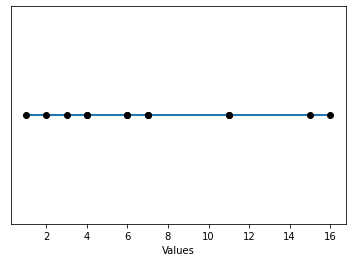

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [[1, 2, 3], [4, 4, 6, 6], [7, 7, 11, 11], [15, 16]]

# Flatten the data list
flat_data = [item for sublist in data for item in sublist]

# Create a figure and axis
fig, ax = plt.subplots()

# Create a horizontal line
ax.hlines(y=0, xmin=min(flat_data), xmax=max(flat_data), linewidth=2)

# Overlay the data points on the line
ax.scatter(flat_data, np.zeros_like(flat_data), color='black', zorder = 2)

# Hide the y-axis
ax.get_yaxis().set_visible(False)

# Set x-axis label
ax.set_xlabel("Values")

# Show the plot
plt.show()


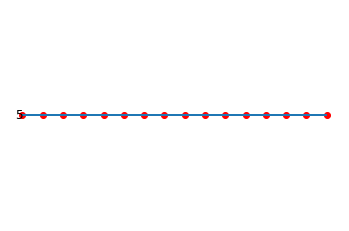

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 16]]

# Flatten the data list
flat_data = [item for sublist in data for item in sublist]

# Create a horizontal line
plt.hlines(y=0, xmin=min(flat_data), xmax=max(flat_data), linewidth=2)

# Overlay the data points on the line
plt.scatter(flat_data, np.zeros_like(flat_data), color='red')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Remove ticks and tick labels
plt.xticks([])
plt.yticks([])

# Add text to the left of the line
plt.text(min(flat_data), 0, '5', verticalalignment='center', horizontalalignment='right', fontsize=12)

# Remove the surrounding box
plt.box(False)

# Show the plot
plt.show()


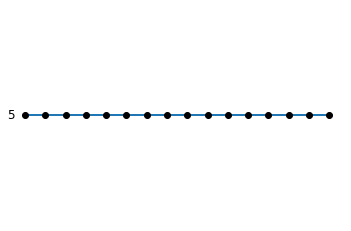

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 16]]

# Flatten the data list
flat_data = [item for sublist in data for item in sublist]

# Create a horizontal line
plt.hlines(y=0, xmin=min(flat_data), xmax=max(flat_data), linewidth=2)

# Overlay the data points on the line
plt.scatter(flat_data, np.zeros_like(flat_data), color='black', zorder = 2)

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Remove ticks and tick labels
plt.xticks([])
plt.yticks([])

# Add text to the left of the line with increased spacing
text_spacing = 0.5
plt.text(min(flat_data) - text_spacing, 0, '5', verticalalignment='center', horizontalalignment='right', fontsize=12)

# Remove the surrounding box
plt.box(False)

# Show the plot
plt.show()


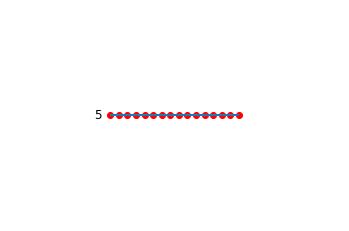

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data = [[1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14], [15, 16]]

# Flatten the data list
flat_data = [item for sublist in data for item in sublist]

# Create a horizontal line
plt.hlines(y=0, xmin=min(flat_data), xmax=max(flat_data), linewidth=2)

# Overlay the data points on the line
plt.scatter(flat_data, np.zeros_like(flat_data), color='red')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Remove ticks and tick labels
plt.xticks([])
plt.yticks([])

# Add text to the left of the line with increased spacing
text_spacing =  1
plt.text(min(flat_data) - text_spacing, 0, '5', verticalalignment='center', horizontalalignment='right', fontsize=12)

# Remove the surrounding box
plt.box(False)

# Scale the plot by adjusting x-axis limits
x_min = min(flat_data)
x_max = max(flat_data)
x_range = x_max - x_min
x_margin = x_range * 0.8  # Adjust the margin as desired
plt.xlim(x_min - x_margin, x_max + x_margin)

# Show the plot
plt.show()
